In [1]:
%matplotlib inline
import h5py

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid', palette='muted', font_scale=1.15)

In [2]:
with h5py.File('elm-events.hdf5', 'r') as f:
    ids = list(f.keys())
    signal_1 = np.array(f[ids[0]]['signals'])
    time_1 = np.array(f[ids[0]]['time'])

    signal_2 = np.array(f[ids[2]]['signals'])
    time_2 = np.array(f[ids[2]]['time'])

signal_1 = signal_1.T
signal_2 = signal_2.T

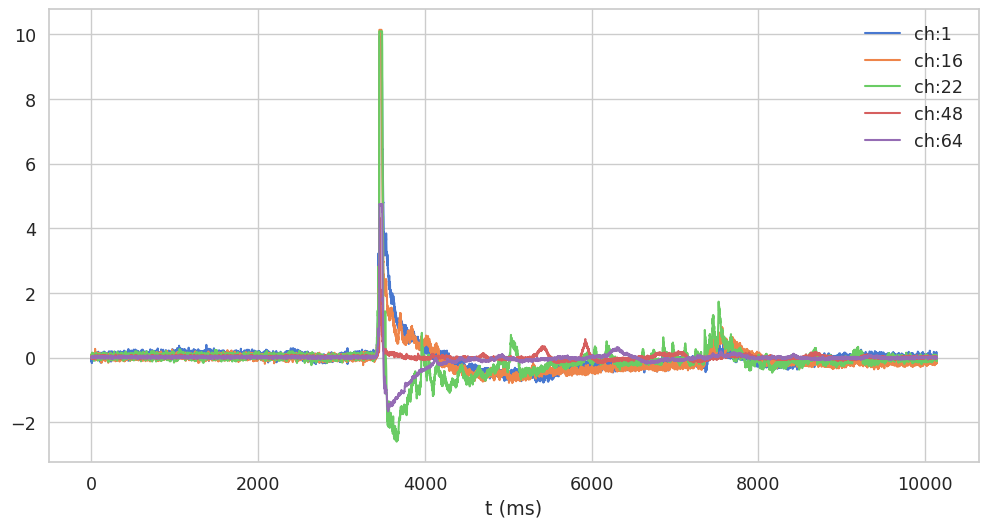

In [3]:
plt.figure(figsize=(12, 6), dpi=100)

for i in [0, 15, 21, 47, 63]:
    plt.plot(signal_1[:, i], label=f'ch:{i+1}')
plt.legend(frameon=False)
plt.xlabel('t (ms)')
plt.show()

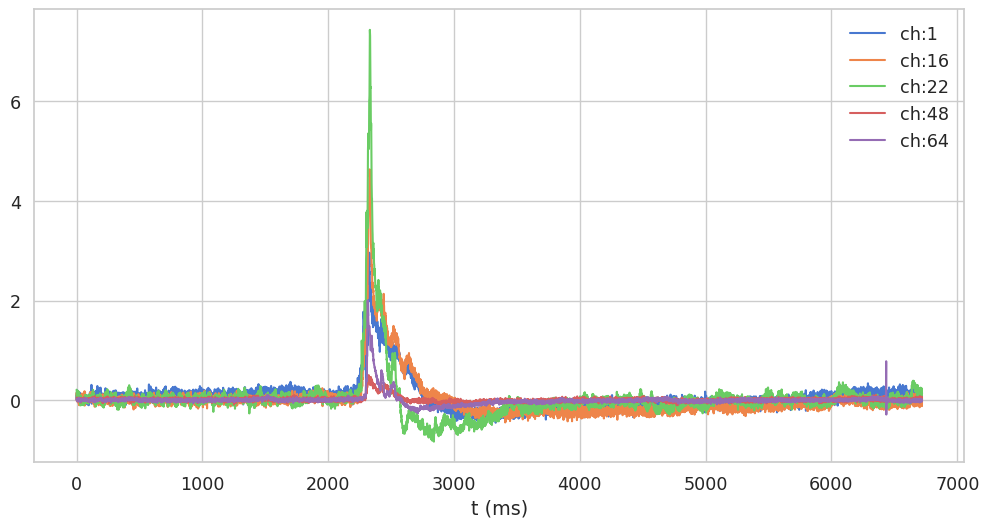

In [4]:
plt.figure(figsize=(12, 6), dpi=100)

for i in [0, 15, 21, 47, 63]:
    plt.plot(signal_2[:, i], label=f'ch:{i+1}')
plt.legend(frameon=False)
plt.xlabel('t (ms)')
plt.show()

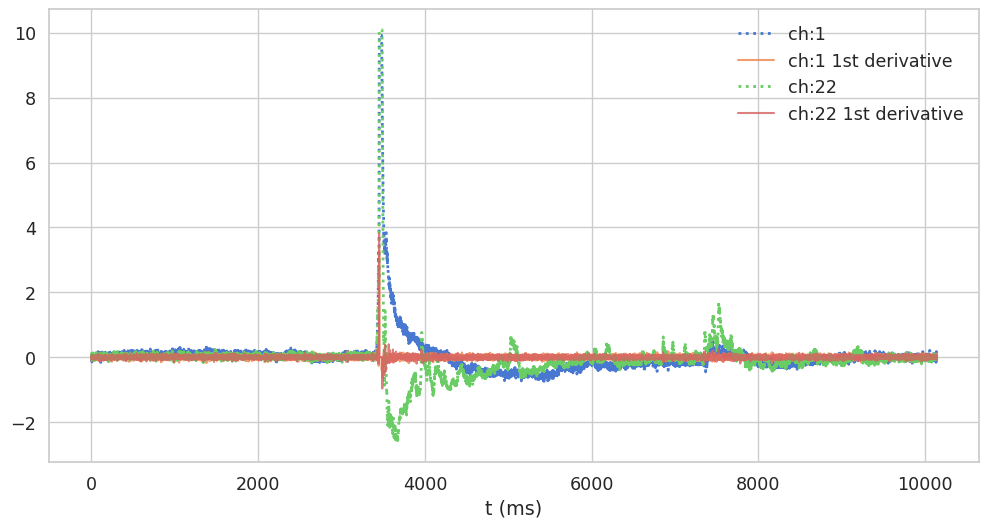

In [24]:
time_grads = np.gradient(signal_1, axis=0)
plt.figure(figsize=(12, 6), dpi=100)

plt.plot(signal_1[:, 0], ls=':', lw=2, label=f'ch:1')
plt.plot(time_grads[:, 0], ls='-', label='ch:1 1st derivative', alpha=0.8)

plt.plot(signal_1[:, 21], ls=':', lw=2, label=f'ch:22')
plt.plot(time_grads[:, 21], ls='-', label='ch:22 1st derivative', alpha=0.8)

plt.legend(frameon=False)
plt.xlabel('t (ms)')
plt.show()

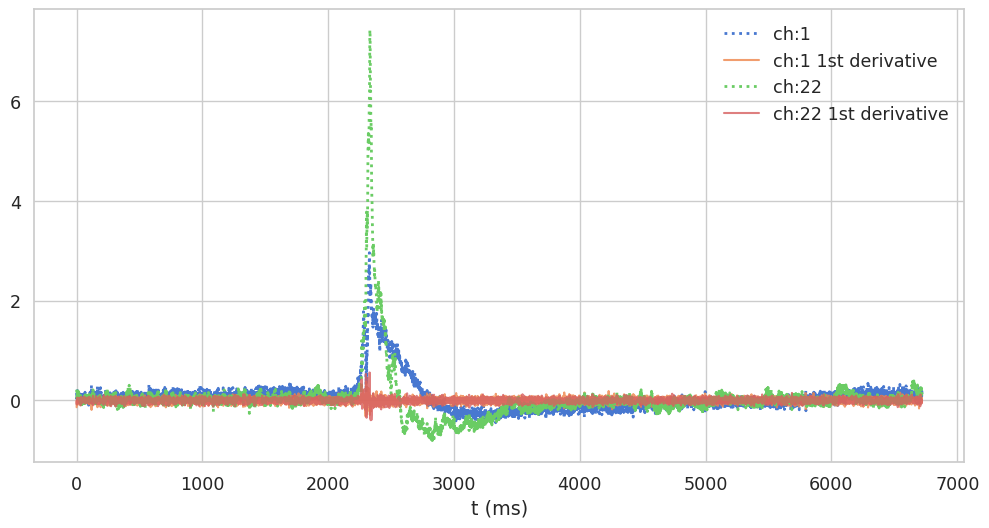

In [25]:
time_grads = np.gradient(signal_2, axis=0)
plt.figure(figsize=(12, 6), dpi=100)

plt.plot(signal_2[:, 0], ls=':', lw=2, label=f'ch:1')
plt.plot(time_grads[:, 0], ls='-', label='ch:1 1st derivative', alpha=0.8)

plt.plot(signal_2[:, 21], ls=':', lw=2, label=f'ch:22')
plt.plot(time_grads[:, 21], ls='-', label='ch:22 1st derivative', alpha=0.8)

plt.legend(frameon=False)
plt.xlabel('t (ms)')
plt.show()